# Credit Card Fraud Detection

## Libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Feature Selection
from sklearn.feature_selection import mutual_info_classif, SelectKBest

# Standardization
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# Divisão treino e teste
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
from yellowbrick.classifier.rocauc import roc_auc
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import auc, plot_precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics

# Hyperparameter selection
from skopt import gp_minimize

In [2]:
data_fraud = pd.read_csv('creditcard_dataset.csv')

In [3]:
data_fraud

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## EDA

The objective is to know and explore the data, identifying patterns/relationships.

In [4]:
data_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

There are 30 variables in the dataset, all numeric:
- Features V1-V28: principal components obtained with PCA (due to confidentiality issues).
- Time: contains the seconds elapsed between each transaction and the first transaction in the dataset.
- Amount: is the transaction Amount
- Class: is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [5]:
# Checking for missing values. # There are no missing values
data_fraud.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [6]:
# Checking data that has been classified as fraud
data_fraud[data_fraud['Class'] ==1][:20]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
6331,7526.0,0.008430,4.137837,-6.240697,6.675732,0.768307,-3.353060,-1.631735,0.154612,-2.795892,...,0.364514,-0.608057,-0.539528,0.128940,1.488481,0.507963,0.735822,0.513574,1.00,1
6334,7535.0,0.026779,4.132464,-6.560600,6.348557,1.329666,-2.513479,-1.689102,0.303253,-3.139409,...,0.370509,-0.576752,-0.669605,-0.759908,1.605056,0.540675,0.737040,0.496699,1.00,1
6336,7543.0,0.329594,3.712889,-5.775935,6.078266,1.667359,-2.420168,-0.812891,0.133080,-2.214311,...,0.156617,-0.652450,-0.551572,-0.716522,1.415717,0.555265,0.530507,0.404474,1.00,1
6338,7551.0,0.316459,3.809076,-5.615159,6.047445,1.554026,-2.651353,-0.746579,0.055586,-2.678679,...,0.208828,-0.511747,-0.583813,-0.219845,1.474753,0.491192,0.518868,0.402528,1.00,1
6427,7610.0,0.725646,2.300894,-5.329976,4.007683,-1.730411,-1.732193,-3.968593,1.063728,-0.486097,...,0.589669,0.109541,0.601045,-0.364700,-1.843078,0.351909,0.594550,0.099372,1.00,1


There are many values of Amount 1 (small financial values) in the Fraud class.

In [7]:
# Statistical summary
pd.set_option('display.max_columns', None) # see all columns
data_fraud.describe(percentiles = [.25, .5, .75, .90, .95, .99]) 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,1.772925e-15,9.289524e-16,-1.803266e-15,1.674888e-15,1.475621e-15,3.501098e-15,1.392460e-15,-7.466538e-16,4.258754e-16,9.019919e-16,5.126845e-16,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
90%,157640.400000,2.015409e+00,1.326635e+00,1.676173e+00,1.482807e+00,1.407893e+00,1.509365e+00,1.039387e+00,7.693811e-01,1.301671e+00,1.119759e+00,1.318588e+00,1.017274e+00,1.251841e+00,9.814085e-01,1.124211e+00,9.908792e-01,9.086165e-01,1.020455e+00,9.538328e-01,4.445929e-01,3.761555e-01,9.148826e-01,3.392860e-01,7.054036e-01,6.009027e-01,6.889469e-01,2.653679e-01,1.799362e-01,203.000000,0.000000
95%,164143.400000,2.081223e+00,1.808585e+00,2.062635e+00,2.566501e+00,2.098960e+00,3.160382e+00,1.407632e+00,1.049984e+00,1.780783e+00,1.548557e+00,1.614033e+00,1.243053e+00,1.607877e+00,1.393653e+00,1.373090e+00,1.325253e+00,1.274609e+00,1.394392e+00,1.286164e+00,8.361441e-01,5.378677e-01,1.128987e+00,4.880160e-01,8.663576e-01,7.606986e-01,9.209154e-01,3.877462e-01,2.560897e-01,365.000000,0.000000
99%,170560.940000,2.237130e+00,3.801811e+00,2.728434e+00,4.248032e+00,3.424903e+00,4.200085e+00,2.696205e+00,2.075973e+00,2.986773e+00,3.253618e+00,2.290583e+00,1.698576e+00,2.513962e+00,

As informed in Kaggle, for security reasons, the real variables are not being shared, they were transformed by PCA. Thus, the variables do not have much discrepancy, with the exception of the Amount and Time variables, which were not transformed by PCA.

The Amount variable has a mean of 88. The mean here is not a good metric to look at this data, since we have a median of 22 and Quartile 3 of 77, that is, 75% of the values are below the mean. The average is being influenced by high values (outliers) of amount. This can also be seen in the standard deviation, which is 250.

Let's look at these metrics by class.

In [8]:
# Colors for the graphics
colors = ['#436DA9', '#E73788']

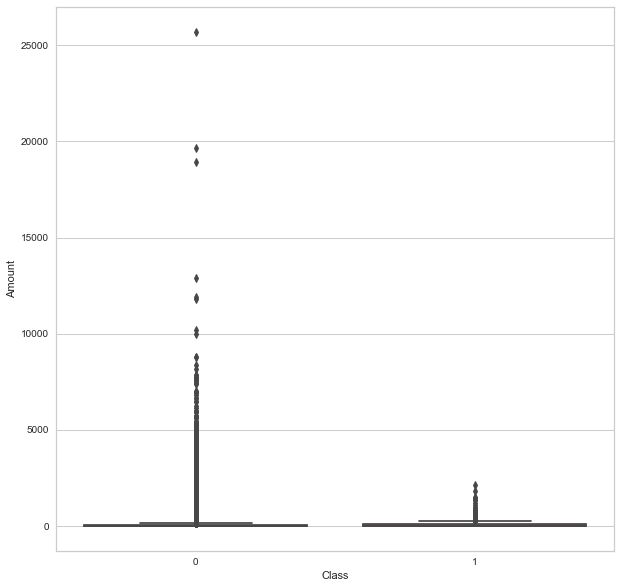

In [9]:
# Distribution of variable class with amount
plt.figure(figsize=(10,10))
sns.boxplot(data=data_fraud, x='Class', y='Amount', palette=colors)
plt.show()

<AxesSubplot:xlabel='Class', ylabel='Amount'>

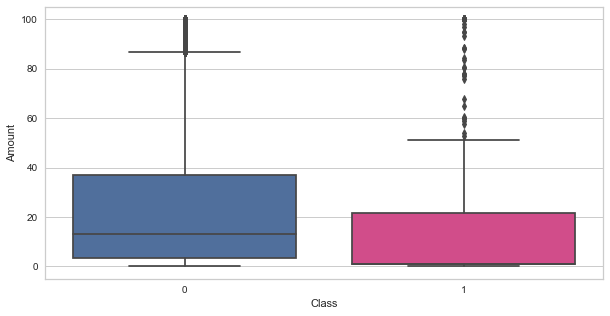

In [10]:
# Distribution of variable class with amount
plt.figure(figsize=(10,5))
sns.boxplot(x = 'Class', y = 'Amount', data = data_fraud[data_fraud.Amount < 1e2], palette=colors)

The graphs above corroborate the conclusions of the statistical summary of the data. Most of the Amount values are below 100, but we have outliers, which are as high as 25,000 in the Non-Fraud Class and are generating a mean much higher than the median of the data, as well as a high standard deviation.

In the case of non-fraud, we have more data between the second and third quartile, which varies from 10 to 40 reais. In the case of fraud, most data are between the second and third quartile, ranging from 1 to 25 reais.

In [11]:
# Statistical summary of amount by class
fraud = data_fraud[data_fraud['Class'] == 1]
notfraud = data_fraud[data_fraud['Class'] == 0]

print("Fraud - statistical summary")
print(fraud["Amount"].describe())
print("\nNot Fraud - statistical summary")
print(notfraud["Amount"].describe())

Fraud - statistical summary
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Not Fraud - statistical summary
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


As seen in the boxplots above, both categories have a similar mean value, but it does not represent the data well, as 75% of them have a value below the mean. Both categories have outliers, but non-fraudulent transactions have outliers with much higher values.

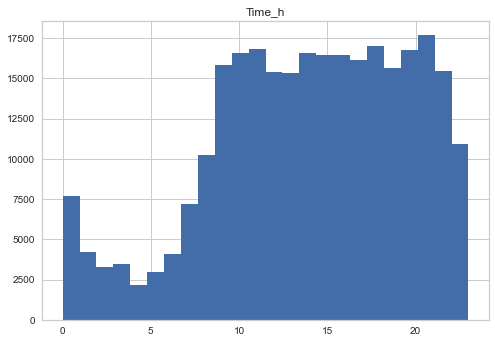

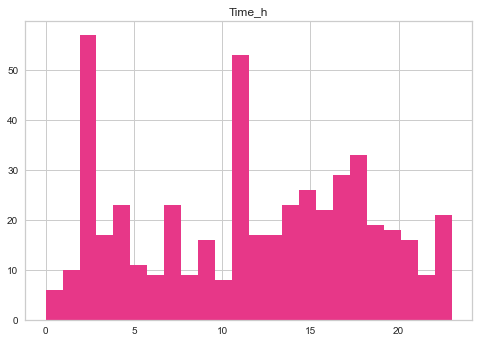

In [12]:
# Time variable is the simulation moment (2 days), in which the transaction is performed. Distribution throughout the day

# Converting Time to hours
timedelta = pd.to_timedelta(data_fraud['Time'], unit='s')
data_fraud['Time_h'] = (timedelta.dt.components.hours).astype(int)

data_fraud.drop(['Time'], axis=1, inplace=True)

# Plotting the 24-hour transaction graph
bins=24
data_fraud[(data_fraud['Class'] == 0)].hist(column="Time_h",color="#436DA9",bins=bins)
data_fraud[(data_fraud['Class'] == 1)].hist(column ="Time_h",color="#E73788",bins=bins)
plt.show()

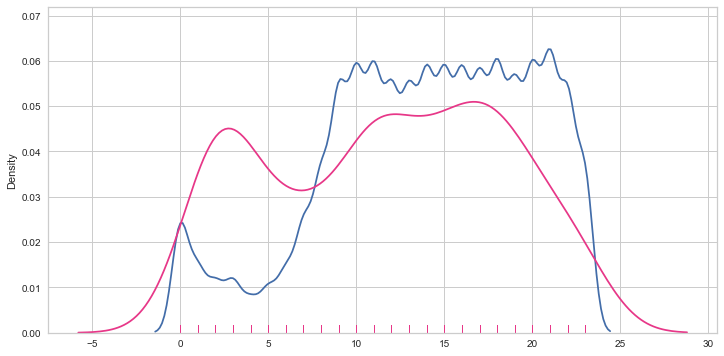

In [13]:
# For a better view of how transactions occur throughout the day
plt.figure(figsize=(12,6))
target_0 = data_fraud.loc[data_fraud['Class'] == 0]
target_1 = data_fraud.loc[data_fraud['Class'] == 1]


sns.distplot(target_0[['Time_h']], hist=False, rug=True, color="#436DA9",)
sns.distplot(target_1[['Time_h']], hist=False, rug=True, color="#E73788")

plt.show()

Fraudulent transactions have a more even distribution, they are evenly distributed over 24 hours. Normal transactions are smaller at night.

In [14]:
# Checking duplicate lines
data_fraud.shape

(284807, 31)

In [15]:
data_fraud.drop_duplicates(inplace=True) # deleting duplicate variables

In [16]:
data_fraud.shape # There were approximately 1000 duplicate data

(280922, 31)

The problem is a case of supervised learning of binary classification, where we use labeled data to train the model, the data contains the desired answer (fraud or non-fraud). Let's analyze the target variable.

[Text(0, 0, 'Not Fraud'), Text(1, 0, 'Fraud')]

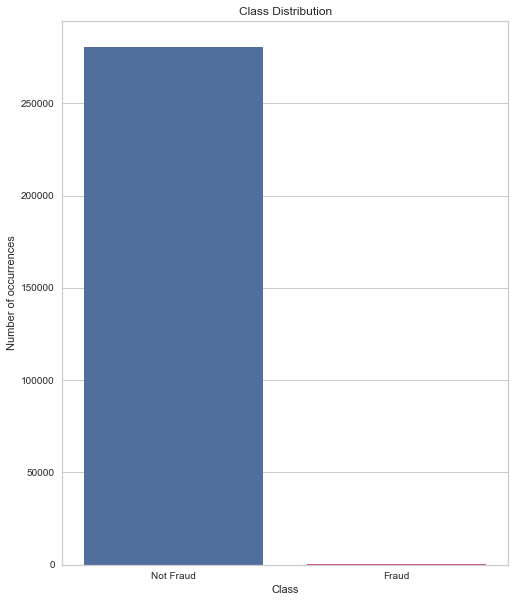

In [17]:
# Checking the distribution of the target class
plt.figure(figsize=(8,10))
g = sns.countplot('Class', data=data_fraud, palette=colors)
g.set_title('Class Distribution')
g.set_ylabel('Number of occurrences')
g.set_xlabel('Class')
g.set_xticklabels(['Not Fraud', 'Fraud'])

In [18]:
# Checking the Fraud Percentage
total = data_fraud['Class'].value_counts()[0] + data_fraud['Class'].value_counts()[1]
fraud = (data_fraud['Class'].value_counts()[1]/total) * 100
print('Fraud percentage:', fraud)

Fraud percentage: 0.16837413944084123


In [20]:
# Checking the data in numbers
total = len(data_fraud)
normal = len(data_fraud[data_fraud.Class == 0])
fraud = len(data_fraud[data_fraud.Class == 1])
print('Total number of transactions: {}'.format(total))
print('Number of Normal Transactions: {}'.format(normal))
print('Number of Fraudulent Transactions: {}'.format(fraud))

Total number of transactions: 280922
Number of Normal Transactions: 280449
Number of Fraudulent Transactions: 473


The target class has two outputs: non-fraud (0) and fraud (1). As expected in banking transactions, fraud cases are much lower than normal transactions. Here, frauds represent only 0.166% of the data (473 out of 280922) which makes the target variable very unbalanced.

#### Let's check the financial impact of fraud cases.

In [21]:
# Amount transacted in 2 days
sum(data_fraud['Amount'])

25037679.49998377

In [22]:
# Amount of fraud
fraud = data_fraud[data_fraud["Class"] == 1]
sum(fraud['Amount'])

58591.38999999999

In [23]:
notfraud = data_fraud[data_fraud["Class"] == 0]
sum(notfraud['Amount'])

24979088.109983813

We handled an amount of R$ 25 billion in 2 days, of which R$ 58,000 were from fraudulent transactions, which represents 0.23% of financial loss with customer reimbursement.

## Seleção de features

We will select the most important features to reduce the risk of overfitting.

In [24]:
# Split features and target
d = data_fraud.iloc[:,:29]
e = data_fraud.iloc[:,30:]
data = pd.concat([d, e], axis=1)
data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Time_h
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,23
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,23
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,23
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,23


In [25]:
target = pd.DataFrame(data_fraud.iloc[:,29])
target

,Class
0,0
1,0
2,0
3,0
4,0
...,...
284802,0
284803,0
284804,0
284805,0


As we don't know what the features are (they went through PCA), let's make a selection of the ones that most contribute to the prediction variable, through Mutual information.

In [26]:
mi = mutual_info_classif(data, target)
mi

array([1.85641092e-03, 2.93588057e-03, 4.62579921e-03, 4.62217039e-03,
       2.08083495e-03, 2.00510090e-03, 3.65129593e-03, 1.61191611e-03,
       3.88174954e-03, 7.20552217e-03, 6.51259450e-03, 7.28054246e-03,
       8.24371774e-05, 7.81016659e-03, 2.32779086e-05, 5.79374086e-03,
       7.93953858e-03, 3.90644531e-03, 1.13791602e-03, 9.03118668e-04,
       2.14751273e-03, 1.22138281e-04, 4.72448178e-04, 3.71304507e-04,
       2.53471234e-04, 2.36286670e-04, 2.17659415e-03, 1.60784096e-03,
       1.47674547e-03, 4.07085957e-03])

In [27]:
# Creating series to better visualize the most important variables
mi = pd.Series(mi)
mi.index = data.columns
mi = mi.sort_values(ascending=False)

<AxesSubplot:>

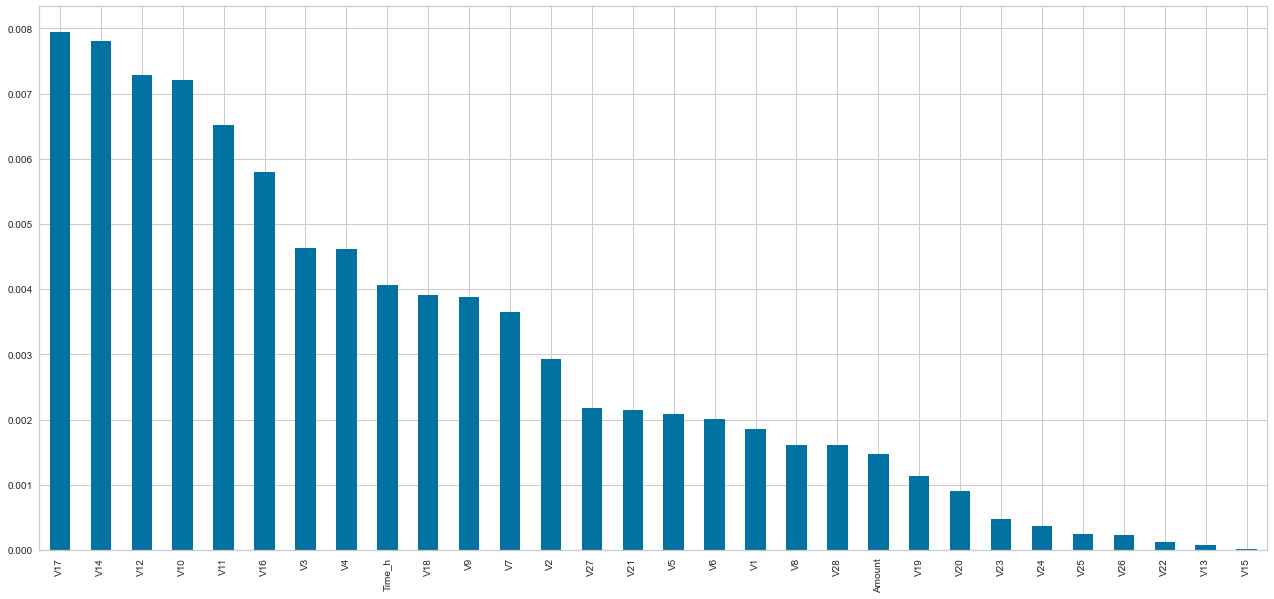

In [28]:
# Plotting the results
mi.plot.bar(figsize=(22,10))

In [29]:
# Selecting the most important features
sel = SelectKBest(mutual_info_classif, k=10).fit(data, target)
data.columns[sel.get_support()]

Index(['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'Time_h'], dtype='object')

We chose the top 10 variables to build the model.

In [30]:
select = data_fraud[['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'Time_h', 'Class']]
select

,V3,V4,V10,V11,V12,V14,V16,V17,V18,Time_h,Class
0,2.536347,1.378155,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0,0
1,0.166480,0.448154,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,0,0
2,1.773209,0.379780,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,0,0
3,1.792993,-0.863291,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,0,0
4,1.548718,0.403034,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0,0
...,...,...,...,...,...,...,...,...,...,...,...
284802,-9.834783,-2.066656,4.356170,-1.593105,2.711941,4.626942,1.107641,1.991691,0.510632,23,0
284803,2.035030,-0.738589,-0.975926,-0.150189,0.915802,-0.675143,-0.711757,-0.025693,-1.221179,23,0
284804,-3.249640,-0.557828,-0.484782,0.411614,0.063119,-0.510602,0.140716,0.313502,0.395652,23,0
284805,0.702510,0.689799,-0.399126,-1.933849,-0.962886,0.449624,-0.608577,0.509928,1.113981,23,0


## Split train and test

In [31]:
X = select.drop(columns = ['Class'])
y = select['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# Stratify to ensure both groups contain the same percentage of fraud cases

We split the data by putting 70% data in “training set” and 30% data in “testing set”, to avoid overfitting. If we use the same data to test the model that was used for training, then the model will perform well, but this is not good as the model memorizes the data and will not provide accurate results for unseen data.

In [32]:
# Training dataset size
len(X_train)

196645

In [33]:
# Test dataset size
len(X_test)

84277

In [35]:
# Checking the percentage of classes in datasets
print('Not fraud:', round(
        y_train.value_counts()[0]/len(y_train)*100, 2), '% from the training dataset')
print('Fraud:', round(
        y_train.value_counts()[1]/len(y_train)*100, 2), '% from the training dataset')

Not fraud: 99.83 % from the training dataset
Fraud: 0.17 % from the training dataset


In [36]:
print('Not fraud:', round(
        y_test.value_counts()[0]/len(y_test)*100, 2), '% from the test dataset')
print('Fraud:', round(
        y_test.value_counts()[1]/len(y_test)*100, 2), '% from the test dataset')

Not fraud: 99.83 % from the test dataset
Fraud: 0.17 % from the test dataset


## Standardization

Let's standardize the data to put it into a common range of values as they can impact model metrics. The model will be able to "learn" that larger values have greater relevance for the forecast, but will have this conclusion under the influence of the column order of magnitude, and not by the importance of the variable itself. We avoid this with the standardization.

In [37]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Random Forest for Classification

In [38]:
RF = RandomForestClassifier(random_state=0)

RF.fit(X_train_scaled, y_train)

predictions = RF.predict(X_test_scaled)

In [39]:
print(classification_report(y_test, RF.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84135
           1       0.95      0.79      0.86       142

    accuracy                           1.00     84277
   macro avg       0.97      0.89      0.93     84277
weighted avg       1.00      1.00      1.00     84277



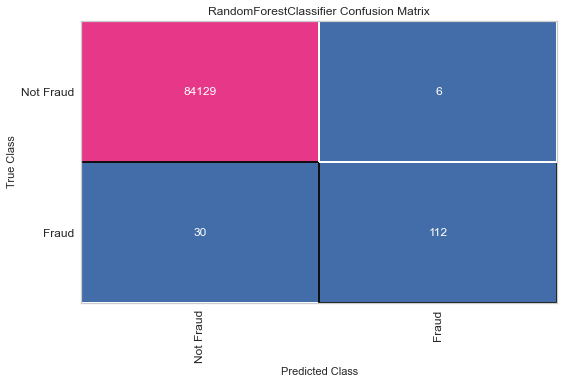

In [40]:
matrix = ConfusionMatrix(RF, classes=['Not Fraud', 'Fraud'], cmap=['#436DA9', '#E73788'])
matrix.fit(X_train_scaled, y_train)
matrix.score(X_test_scaled, y_test)
matrix.show();

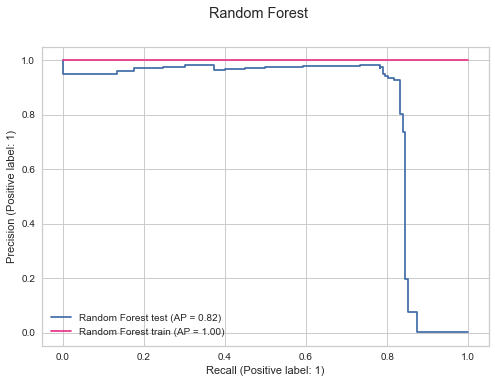

In [41]:
# As the classes are unbalanced, the AP curve will be considered for the evaluation of the model
display2 = PrecisionRecallDisplay.from_estimator(RF, X_test_scaled, y_test, name="Random Forest test", color='#436DA9')
display2 = PrecisionRecallDisplay.from_estimator(RF, X_train_scaled, y_train, name="Random Forest train", color='#E73788', ax=display2.ax_ )
display2.figure_.suptitle("Random Forest")
plt.show()

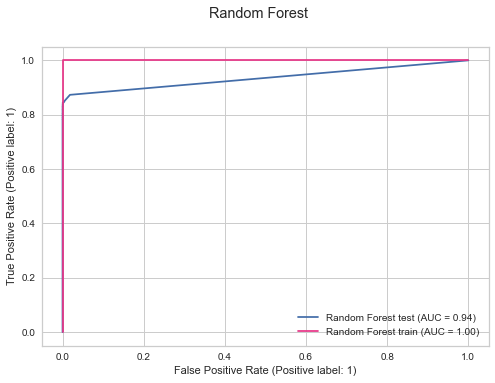

In [42]:
# Just looking at the ROC curve out of curiosity.
rff = metrics.plot_roc_curve(RF, X_test_scaled, y_test, name='Random Forest test', color='#436DA9')
rff = metrics.plot_roc_curve(RF, X_train_scaled, y_train, name='Random Forest train', color='#E73788', ax=rff.ax_)
rff.figure_.suptitle("Random Forest")

plt.show()

We had good results, so let's cross-validate for evaluation.

## Cross validation

In [43]:
#Cross validation of recall
recallRF = cross_val_score(RF, X_train_scaled, y_train, cv=5, scoring='recall')

In [44]:
print(recallRF)

[0.74242424 0.77272727 0.74242424 0.78787879 0.7761194 ]


In [45]:
print(recallRF.mean())

0.7643147896879241


In [46]:
print(recallRF.std())

0.01856756793836276


In [47]:
def interval(recallRF):
    mean = recallRF.mean()
    dv = recallRF.std()
    print('Recall mean: {:.2f}%'.format(mean*100))
    print('Recall interval: [{:.2f}% ~ {:.2f}%]'
           .format((mean - 2*dv)*100, (mean + 2*dv)*100))
interval(recallRF)

Recall mean: 76.43%
Recall interval: [72.72% ~ 80.14%]


## Hyperparameters

In [48]:
# Checking parameters RandomForest
?RandomForestClassifier

Let's try to improve the model. For this, we are going to use some Random Forest hyperparameters.

## Bayesian Optimization

In [49]:
# Checking which are the best hyperparameters that improve the AP curve

def train_model(params):
    max_features = params[0]
    n_estimators = params[1]
    max_depth = params[2]

    
    print(params, '\n') # prints which parameters are testing on each iteration
    
    mdl = RandomForestClassifier(max_features=max_features, n_estimators=n_estimators,
                        max_depth=max_depth, random_state=0, n_jobs=-1)
    mdl.fit(X_train_scaled, y_train)
    
    predictions = mdl.predict(X_test_scaled)
    
    return -average_precision_score(y_test, predictions) 
# The returned metric will be the one chosen to check if the model is good due to imbalance

# Minimum and maximum parameter values
space = [(0.1, 1.0), # max_features
         (100, 500), # n_estimators
         (1, 8)] # max_depth

In [50]:
results_gp = gp_minimize(train_model, space, 
                            random_state=1, 
                            verbose=1, #show process
                            n_calls=30, # number of interactions it will test
                            n_random_starts=10) #tests 10-point samples at random, then trains the model and finds which 
# parameter was most promising, and from there tests parameters that seem most optimal and explores them rather than doing 
# it randomly. Explore promising areas and explore areas that look better

Iteration No: 1 started. Evaluating function at random point.
[0.997466329844982, 473, 2] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 38.6102
Function value obtained: -0.6098
Current minimum: -0.6098
Iteration No: 2 started. Evaluating function at random point.
[0.9991364637917305, 194, 4] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 30.6839
Function value obtained: -0.6868
Current minimum: -0.6868
Iteration No: 3 started. Evaluating function at random point.
[0.44911966704580675, 368, 8] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 60.2234
Function value obtained: -0.7554
Current minimum: -0.7554
Iteration No: 4 started. Evaluating function at random point.
[0.8616798250174156, 225, 5] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 46.3638
Function value obtained: -0.7514
Current minimum: -0.7554
Iteration No: 5 started. Evaluating function at random point.
[0.49910760440160107, 192, 5] 

In [51]:
# Checking the best hyperparameters
results_gp.x

[0.5502498873280508, 498, 7]

## Running the model with the hyperparameters

In [52]:
RF2 = RandomForestClassifier(random_state=0, max_features=0.55, n_estimators=498, max_depth=7)

RF2.fit(X_train_scaled, y_train)

predictions2 = RF2.predict(X_test_scaled)

In [53]:
print(confusion_matrix(y_test, predictions2))
print(classification_report(y_test, RF.predict(X_test_scaled)))

[[84131     4]
 [   27   115]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84135
           1       0.95      0.79      0.86       142

    accuracy                           1.00     84277
   macro avg       0.97      0.89      0.93     84277
weighted avg       1.00      1.00      1.00     84277



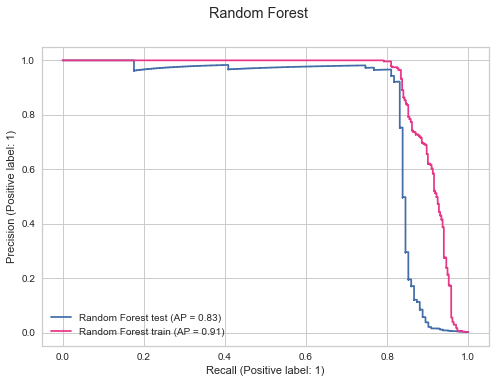

In [54]:
display2 = PrecisionRecallDisplay.from_estimator(RF2, X_test_scaled, y_test, name="Random Forest test", color='#436DA9')
display2 = PrecisionRecallDisplay.from_estimator(RF2, X_train_scaled, y_train, name="Random Forest train", color='#E73788', ax=display2.ax_ )
display2.figure_.suptitle("Random Forest")
plt.show()

Even looking for better hyperparameters, the model didn't have many gains. However, the end result is considered good.

## Conclusions

- The model correctly classified 84131 non-fraud transactions
- The model classified only 4 true transactions as fraud (here we have the lowest number of customers with transactions being barred, as our objective was also to avoid classifying good customers as suspicious as much as possible)
- The model correctly classified 115 frauds
- The model classified 27 frauds as true transactions